In [1]:
import numpy as np
import pandas as pd
import cv2 as cv

In [2]:
landmarks = ["Root", "Forehead", "Left Eye", "Left Ear", "Left Shoulder", "Left Waist", "Right Eye", "Right Ear", "Right Shoulder", "Right Waist", "Nose", "Left Elbow", "Left Knee", "Right Elbow", "Right Knee", "Left Wrist", "Left Foot", "Right Wrist", "Right Foot"]
limbs = {"Root":[1], "Forehead":[10,2,3,6,7,4,5,8,9], "Left Shoulder":[11], "Left Elbow": [15], "Left Waist":[12], "Left Knee": [16], "Right Shoulder":[13], "Right Elbow": [17], "Right Waist":[14], "Right Knee": [18]}
possible_duplicates = [1,11,12,13,14]

In [3]:
class Link:

  def __init__(self, landmark, possible = False):
    self.landmark_type = landmark
    self.parent = self
    self.children = []
    self.next_child = 0
    self.duplicate_possible = possible
  
  def add_parent(self, parent):
    self.parent = parent

  def add_child(self, child):
    self.children.append(child)

  def get_type(self):
    return self.landmark_type

  def get_parent(self):
    return self.parent

  def check_over(self):
    if(self.next_child == len(self.children)):
      
      return(True)
    else:
      return(False)
  
  

class Chain:

  def __init__(self, landmarks, limbs, possible_duplicates):
    self.landmarks = landmarks
    self.limbs = limbs
    self.possible_duplicates = possible_duplicates
    self.links = {}
    for i, landmark in enumerate(self.landmarks):
      if(i in self.possible_duplicates):
        link = Link(landmark, True)
      else:
        link = Link(landmark, False)
      self.links[landmark] = link

    self.links["Root"].add_parent(None)

    for limb in limbs:
      parent = self.links[limb]
      for i in limbs[limb]:
        self.links[self.landmarks[i]].add_parent(parent)
        self.links[parent.get_type()].add_child(self.links[self.landmarks[i]])

  def get_root(self):
    return self.links["Root"]
  
  


  def traverse(self):
      next = self.links["Root"]
      while(next is not None):
        print(next.get_type())
        next, _ = next.successor()
        


In [176]:
class Final_Annotation():

  def __init__(self):
    self.annotations = {"id":[],"pid":[], "type": [], "x":[], "y": [], "attr":[], "person":[], "img_id":[]}
    self.next_id = 0
    self.roots = []

  def append(self,annot):
    for col in self.annotations:
      self.annotations[col] = self.annotations[col] + annot.tree[col]
    self.next_id += annot.count
    self.roots = self.roots + annot.roots
    return(self.next_id)

In [177]:
class Annotation_noGUI:

  def __init__(self, landmarks, limbs, possible_duplicates, person_id = -1, img_id = 'I-1'):
    self.tree = {"id":[],"pid":[], "type": [], "x":[], "y": [], "attr":[], "person":[], "img_id":[]}
    self.count = 0
    self.landmarks = landmarks
    self.img_id = img_id
    self.limbs = limbs
    self.possible_duplicates = possible_duplicates
    self.chain = None
    self.roots = []
    self.current_root = None
    self.current_id = None
    self.person_id = person_id
    
    self.next_link = None
    self.parent_link = None
    self.current_parent = None
    self.img = None
    self.pane = np.zeros((256,256, 3), np.uint8)
    self.temp_pane = None
    self.menu = None
    self.menuText = ''
    self.temp_entry = {}
    self.elements = {"yes":[], "no":[]}
    self.over = False

    self.state = 'main'
    
    self.elements = []
    

#get/set state variable
  def get_state(self):
    return(self.state)
  
  def set_state(self, state):
    self.state = state


  

#find successor link a well as id from a position after selection. If up, find next successor before selection
  def successor(self, up = False):

    
    if(up):
          if(self.next_link.duplicate_possible):
            self.parent_link.next_child += 1
          else:
            pass

          self.next_link = self.parent_link
          if(self.next_link.get_type() == "Root"):
            return (-1)
          
          self.current_parent = self.tree['pid'][self.current_id]
          self.parent_link = self.next_link.parent
          
          
          self.successor()
          return


    if(self.next_link.next_child < len(self.next_link.children)):
          
          tmp = self.next_link.next_child
          self.parent_link = self.next_link 
          self.current_parent = self.current_id
          self.next_link = self.next_link.children[tmp]
          
          if(self.next_link.duplicate_possible):
            pass
            
          else:
            self.parent_link.next_child += 1
          
          
            
          

    else:
          self.next_link.next_child = 0
          self.next_link = self.parent_link
          
          

          self.current_id = self.current_parent
          
          self.current_parent = self.tree['pid'][self.current_id]
          self.parent_link = self.next_link.parent
          
          self.successor()
    
          
          
    
    
    
    
#Initialising functions
  def add_root(self, attr = ''):

    id = self.count
    self.tree['id'].append(id)
    self.tree['pid'].append(-1)
    self.tree['type'].append("Root")
    self.tree['x'].append(0)
    self.tree['y'].append(0)
    self.tree['attr'].append(attr)
    self.tree['person'].append(self.person_id)
    self.tree['img_id'].append(self.img_id)
    self.current_id = id
    self.count += 1
    self.state = 'select'
    self.current_parent = id
    self.parent_link = self.chain.get_root()
    self.next_link = self.parent_link
    
    return(id)
  
  def start_annotation(self):
    if(self.state != 'main'):
      return(-1)
    
    self.chain = Chain(landmarks, limbs, possible_duplicates)
    self.current_id = self.add_root()
    self.current_root = self.current_id
    self.roots.append(self.current_id)
    return(0)

#Entry functions

  def capture(self, x,y):
    if(self.state == 'select'):
      
      l_type = self.next_link.get_type()
      self.temp_add(l_type, x, y, '')
      #self.draw_point_on_pane(x,y)
  
  def temp_add(self, l_type, x, y, attr = ''):
    self.temp_entry["type"] = l_type
    self.temp_entry['x'] = x
    self.temp_entry['y'] = y
    self.temp_entry['attr'] = attr
    


  def add_entry(self):

    id = self.count
    self.tree['id'].append(id)
    self.tree['pid'].append(self.current_parent)
    self.tree['type'].append(self.temp_entry["type"])
    self.tree['x'].append(self.temp_entry['x'])
    self.tree['y'].append(self.temp_entry['y'])
    self.tree['attr'].append(self.temp_entry['attr'])
    self.tree['person'].append(self.person_id)
    self.tree['img_id'].append(self.img_id)
    self.current_id = id
    print(self.tree['type'][self.current_id] + " Added with id {}".format(self.current_id))

    self.count += 1
    out = self.successor()
    
    return(id)




#Logic for Annotation Progression
  def do_confirm(self, i):

    if(self.next_link.get_type() == 'Root'):
        self.successor()
        self.state = 'select'
        print('Select A(An) ' + self.next_link.get_type() + ' For the person')
        
        
        return(0)

    
    if(i == 0):
      
      self.add_entry()
      
      self.temp_entry = {}
      #self.refresh_pane(self.current_id)
      




      
      if(self.next_link.get_type() == 'Root'):
        return(-1)

      
      self.state = 'select'
      print('Select A(An) ' + self.next_link.get_type() + ' connected to previously selected ' + self.parent_link.get_type() + " {}.".format(self.tree['id'][self.current_parent]))
        
    
    else:
      self.temp_entry = {}
      self.state = 'select'
      print('Select again')
      #self.refresh_pane(self.current_id)
    
    
    
    return(0)


  def do_select(self, x, y):
    if(self.state == 'select'):
      self.capture(x,y)
      
      self.state = 'confirm' 
      #self.draw_confirmation(x,y)   

    

#Logic for jumping children etc
  def next_child(self):
    
      
      out = self.successor(up = True)
      if(self.next_link.get_type() == 'Root'):
        return(-1)
      
      
      self.state = 'select'
      print('Select A(An) ' + self.next_link.get_type() + ' connected to previously selected ' + self.parent_link.get_type() + " {}.".format(self.tree['id'][self.current_parent]))
    
      
        
  def set_child(self, id):
    if(id <= self.parent_link.next_child):
        pass
    else:
        self.parent_link.next_child = id
    
  def go_up(self):
    
          self.next_link = self.parent_link
          if(self.next_link.get_type() == "Root"):
            return (-1)
          
          self.current_parent = self.tree['pid'][self.current_id]
          self.parent_link = self.next_link.parent
          
          
          self.successor()
          
      
      
          self.state = 'select'
          print('Select A(An) ' + self.next_link.get_type() + ' connected to previously selected ' + self.parent_link.get_type() + " {}.".format(self.tree['id'][self.current_parent]))
          self.generate_menu_elements()

        
#GUI Functions. In progress
  def draw_circle(self, x,y, type = 0):
        if (type == 0):
            self.tmp = self.pane.copy()
            cv.circle(self.pane, (x,y), 10, color = (0,255,255), thickness = -1)
            return(0)
        elif (type == 1):
            self.tmp = self.pane.copy()
            cv.circle(self.pane, (x,y), 10, color = (0,255,0), thickness = -1)
        else:
            self.tmp.pane.copy()
            cv.circle(self.pane, (x,y), 10, color = (0,255,0), thickness = -1)
            cv.circle(self.pane, (x,y), 15, color = (0,255,0), thickness = 2)
            
  def within(self, x, y):
        
        for element in self.elements:
            if(element['type'] == 'circle'):
                cx,cy, r = element['dim']
                if(((cx-x)**2 + (cy - y)**2) < r**2):
                    return(element['id'])
                
            elif(element['type'] == 'rect'):
                lx,ly,w,h = element['dim']
                if((x>lx) and (x < lx+w)) and ((y > ly) and (y < ly+h)):
                    return(element['id'])
    
  def draw_line(self,p1,p2):
        cv.line(self.pane, p1, p2, color = (255,255,255), thickness = 2)
        
  def draw_rect_element(self, p1, p2, text, status = 0):
        palette = np.zeros((100,130,3), np.uint8)
        
        if(status == 0):
            color = (0,0,255)
            text_color = (0,0,0)
        elif(status == 1):
            color = (0,255,255)
            text_color = (0,255,0)
        elif(status ==  2):
            color = (0,255,0)
            text_color = (0,255,255)
        elif(status == 3):
            colour = (255,0,0)
            text_color = (255,255,255)
            
        cv.rectangle(self.menu, p1, p2, color = color, thickness = -1)
        cv.putText(palette, text, org = (p1[0] + 15,p1[1] + 15), fontFace = cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=text_color,thickness=2)
        
    
  def generate_menu_elements(self):
        
        num = len(self.parent_link.children)
        self.elements = []
        x = 15
        y = 0
        y_gap = 15
        for i, child in enumerate(self.parent_link.children):
            element['type'] = child.get_type()
            element['id'] = i
           
            
        
        
            
            
        

In [178]:


#user interface
def tool_noGUI(img_name, All_annotations, img = None):
  
  person_id = 0
  
  

  
  
  to_save = True
  while(True):
    annot = Annotation_noGUI(landmarks, limbs, possible_duplicates, person_id = person_id, img_id = img_name)
    
    
    
    annot.start_annotation()
    print("Startting New Person")
    print("Select a landmark")
    annot.do_confirm(0)
    
    

    
    
    while(True):

        state = annot.get_state()
      
      
        if(state == 'select'):
            #gui.add_message("Select Next Landmark", "")
            ok = input("Select Point (Dummy type y/q/n/u)")
            if(ok == 'y'):
              
              annot.do_select(0,0)
                
            elif(ok == 'q'):
              save = input("Annotation of current person may be incomplete. Want to save?")
              if(save == 'y'):
                to_save = True
              else:
                to_save = False
              print("Quitting annotation of current person")
              break
            elif(ok == 'n'):
              
              res = annot.next_child()
              if(res == -1):
                    break
                
            elif(ok == 'u'):
                annot.set_child(len(annot.parent_link.children))
                res = annot.go_up()
              
                if(res == -1):
                    break
            else:
              print("wrong selection")
            

        elif(state == 'confirm'):
            ok = input("Confirm selection ")
            if(ok == 'y'):

                res = annot.do_confirm(0)
            else:
                res = annot.do_confirm(1)
            
            if(res == -1):
                break

          
        
        elif(state == 'main'):
            pass
    
    if(to_save):
      next_id = All_annotations.append(annot)
      #print(annot.tree['id'])

    res = input("more persons in the image? ")
    

    if(res == 'n'):
      break
    else:
      to_save = True
    
    person_id += 1

#file = pd.DataFrame(All_annotations)

    
       


In [179]:
#driver code

if(__name__ == "__main__"):
    All_annotations = Final_Annotation()
    tool_noGUI('img_name', All_annotations, img = None)
    a = All_annotations.annotations
    for i in range(len(a['id'])):
        print(a["img_id"][i], a['person'][i], a['id'][i], a['pid'][i], a['type'][i])

Startting New Person
Select a landmark
Select A(An) Forehead For the person
Select Point (Dummy type y/q/n/u)y
Confirm selection y
Forehead Added with id 1
Select A(An) Nose connected to previously selected Forehead 1.
Select Point (Dummy type y/q/n/u)y
Confirm selection y
Nose Added with id 2
Select A(An) Left Eye connected to previously selected Forehead 1.
Select Point (Dummy type y/q/n/u)y
Confirm selection y
Left Eye Added with id 3
Select A(An) Left Ear connected to previously selected Forehead 1.
Select Point (Dummy type y/q/n/u)y
Confirm selection y
Left Ear Added with id 4
Select A(An) Right Eye connected to previously selected Forehead 1.
Select Point (Dummy type y/q/n/u)y
Confirm selection y
Right Eye Added with id 5
Select A(An) Right Ear connected to previously selected Forehead 1.
Select Point (Dummy type y/q/n/u)y
Confirm selection y
Right Ear Added with id 6
Select A(An) Left Shoulder connected to previously selected Forehead 1.
Select Point (Dummy type y/q/n/u)y
Confir

In [17]:


class Element:
    
    def __init__(self,text, duplicate, offset, dim):
        self. x_offset = offset[0]
        self.y_offset = offset[1]
        self.color1 = [(0,255,0),(255,0,0),(0,255,255),(0,0,0)]
        self.color2 = [(0,0,0),(255,255,255),(0,0,0),(255,255,255)]
        self.dim = dim
        self.text = text
        self.state = 0
        
        
    def set_state(self, state):
        self.state = state
        
    def get_state(self):
        return self.state
    
    def has(self,x,y, menu_offset):
        if((x > menu_offset[0] + self.x_offset) and (x < menu_offset[0] + self.x_offset + self.dim[0]) and (y > menu_offset[1] + self.y_offset) and (y < menu_offset[1] + self.y_offset + self.dim[1])):
           return (True)
        return (False)
    
    def set_back_color(self,color):
        self.color1.append(color)
        return(len(self.color1) - 1)
        
    def set_font_color(self,color):
        self.color1.append(color)
        return(len(self.color1) - 1)
        

class Gui:
    
    def __init__(self):
        
        self.image = None
        self.msg1 = None
        self.msg2 = None
        self.elements = []
        self.image_controls = []
        
        self.scale = 1.0
        self.x_pan = 0
        self.y_pan = 0
        
        
        #nth child element is to be highlighted
        self.num = 0
        
        
        self.image_offset = (5,5)
        self.message_offset = (0,630)
        self.menu_offset = (900,0)
        self.message_size = (900,130)
        self.menu_size = (128,760)
        self.image_size = (900,630)
        
        
        self.current_list = []
        
        self.base = np.zeros((760,1028,3), np.uint8)
        self.message_pane_base = np.zeros((130,900,3), np.uint8)
        self.message_pane_base[:,:,1] = np.ones((130,900), np.uint8) * 64
        self.message_pane_base[:,:,2] = np.ones((130,900), np.uint8) * 140
        self.menu_pane_base = np.zeros((760,128,3), np.uint8)
        self.menu_pane_base[:,:,1] = np.ones((760,128), np.uint8)
        self.menu_pane_base[:,:,2] = np.ones((760,128), np.uint8) * 128
        self.image_pane_base = np.zeros((630,900,3), np.uint8)
        
        self.window = self.base.copy()
        self.image_pane = self.image_pane_base.copy()
        self.menu_pane = self.menu_pane_base.copy()
        self.message_pane = self.message_pane_base.copy()
        self.temp_pane = self.image_pane.copy()
        
        
        
        
        
    
    def add_message(self, msg1 = None, msg2 = None, retain = True):
        if(retain):
            if(msg1 is None):
                pass
            else:
                self.msg1 = msg1
            if(msg2 is None):
                pass
            else:
                self.msg2 = msg2
        
        else:
            if(msg1 is None):
                self.msg1 = ''
            else:
                self.msg1 = msg1
            if(msg2 is None):
                self.msg1 = ''
            else:
                self.msg2 = msg2
    
    def add_elements(self, current):
        self.current_link = current
        current_children = self.current_link.children
        gap = int(600/(len(current_children)+1) - 30)
        offset = gap+50
        for i in current_children:
            element = Element(i.get_type(), i.duplicate_possible, (10,offset), (100,30))
            offset += gap + 30
            self.elements.append(element)
        self.elements[0].set_state(1)
    
    def add_image_controls(self):
        self.image_controls.append(Element('+', False, (10,650),(40,40)))
        self.image_controls.append(Element('-', False, (80,650),(40,40)))
        self.image_controls.append(Element('->', False, (80,720),(40,40)))
        self.image_controls.append(Element('<-', False, (10,720),(40,40)))
    
    def add_image(self, img):
        self.image = img
        
        width = img.shape[1]
        height = img.shape[0]
        
        sc_x = self.image_size[0]/width
        sc_y = self.image_size[1]/height
        self.scale = min(sc_x, sc_y)
    
    def compose_image(self):
        scale = self.scale
        x_pan = self.x_pan
        y_pan = self.y_pan
        x_pos = 0
        y_pos = 0
        cp = self.image.copy()
        width = cp.shape[1]
        height = cp.shape[0]
        
        sc_width = int(scale * width)
        sc_height = int(scale * height)
        self.x_pan = min(self.x_pan, sc_width - self.image_size[0])
        self.y_pan = min(self.y_pan, sc_height - self.image_size[1])
        
        if(sc_width <= self.image_size[0]):
            x_pan = 0
            self.x_pan = 0
            x_pos = int((self.image_size[0] - sc_width)/2)
        
        if(sc_height <= self.image_size[1]):
            y_pan = 0
            self.y_pan = 0
            y_pos = int((self.image_size[1] - sc_height)/2)
        
        
        
        cp = cv.resize(cp, (sc_width, sc_height))
        
        im_width = int(min(sc_width, self.image_size[0]))
        im_height = int(min(sc_height, self.image_size[1]))
        cp = cp[self.y_pan:self.y_pan + im_height, self.x_pan:self.x_pan + im_width,:]
        
        
        self.image_pane[y_pos:y_pos+im_height, x_pos: x_pos + im_width,:] = cp
        
        
        
    
    def set_current_element(self, num):
        print(self.num)
        if(num <= self.num):
            return(-1)
        if(num > len(self.elements)):
            return(-1)
        for i in range(num):
            self.elements[i].set_state(2)
        
        self.elements[num].set_state(1)
        self.num = num
        
    def image_position(self, num):
        if(num == 0):
            self.scale = self.scale * 1.1
        elif (num == 1):
            if(self.image.shape[1] * self.scale < self.image_size[0]) and (self.image.shape[0] * self.scale < self.image_size[1]):
                pass
            else:
                self.scale = self.scale / 1.1
        elif (num == 2):
            inc = int(min(50, self.image.shape[1] * self.scale - self.x_pan - self.image_size[0]))
            inc = max(0, inc)
            self.x_pan += inc
        elif (num == 3):
            inc = min(50, self.x_pan)
            self.x_pan -= inc
    
    def check_within(self, x, y):
        #print(x,y)
        for i, element in enumerate(self.elements):
            if (element.has(x,y, self.menu_offset)):
                return(i)
            
        return(-1)
    
    def check_image_controls(self, x, y):
        #print(x,y)
        for i, element in enumerate(self.image_controls):
            if (element.has(x,y, self.menu_offset)):
                return(i)
            
        return(-1)
        
    
    def compose_message(self):
        
        pane = cv.putText(self.message_pane, self.msg1, (20,40), fontFace = cv.FONT_HERSHEY_SIMPLEX, fontScale = 1.5, color =  (0,255,255), thickness = 2)
        self.message_pane = cv.putText(pane, self.msg2, (20,100), fontFace = cv.FONT_HERSHEY_SIMPLEX, fontScale = 1, color =  (0,255,255), thickness = 2)
     
    
    def compose_menu(self):
        
        scale = 1.0
        name = self.current_link.get_type()
        l = len(name)
        if(l <= 8):
                scale = 0.75
        else:
                scale = 6.0/l
        self.menu_pane = cv.putText(self.menu_pane, name, (15, 35), fontFace = cv.FONT_HERSHEY_SIMPLEX, fontScale = scale, color = (0,255,255), thickness = 3  )
        
        for i in self.elements:
            
            l = len(i.text)
            if(l <= 12):
                scale = 0.5
            else:
                scale = 6.0/l
                
            color1 = i.color1[i.state]
            color2 = i.color2[i.state]
            init_y = i.y_offset
            init_x = i.x_offset
            self.menu_pane = cv.rectangle(self.menu_pane, (init_x, init_y), (init_x + i.dim[0], init_y + i.dim[1]), color = color1, thickness = -1 )
            self.menu_pane = cv.putText(self.menu_pane, i.text, (init_x+5, init_y + 15), fontFace = cv.FONT_HERSHEY_SIMPLEX, fontScale = scale, color = color2, thickness = 2  )
        
        for i in self.image_controls:
            
            init_y = i.y_offset
            init_x = i.x_offset
            self.menu_pane = cv.rectangle(self.menu_pane, (init_x, init_y), (init_x + i.dim[0], init_y + i.dim[1]), color = color1, thickness = -1 )
            self.menu_pane = cv.putText(self.menu_pane, i.text, (init_x+5, init_y + 15), fontFace = cv.FONT_HERSHEY_SIMPLEX, fontScale = scale, color = color2, thickness = 3  )


        
    def compose(self):
        self.compose_message()
        self.compose_menu()
        self.compose_image()
        self.window[self.message_offset[1]:self.message_offset[1] + self.message_size[1], self.message_offset[0]:self.message_offset[0] + self.message_size[0],:] = self.message_pane
        self.window[self.menu_offset[1]:self.menu_offset[1] + self.menu_size[1], self.menu_offset[0]:self.menu_offset[0] + self.menu_size[0],:] = self.menu_pane
        self.window[self.image_offset[1]:self.image_offset[1] + self.image_size[1], self.image_offset[0]:self.image_offset[0] + self.image_size[0],:] = self.image_pane
        self.menu_pane = self.menu_pane_base.copy()
        self.message_pane = self.message_pane_base.copy()
        self.image_pane = self.image_pane_base.copy()
        return self.window.copy()
        

In [18]:
def handler(event, x, y, flags, params):
    if(event == cv.EVENT_LBUTTONUP):
        num = gui.check_within(x,y)
        if num > -1:
            gui.set_current_element(num)
        
        else:
            num = gui.check_image_controls(x,y)
            if (num == -1):
                return(-1)
            gui.image_position(num)
        

In [19]:

gui = Gui()
chain = Chain(landmarks, limbs, possible_duplicates)
root = chain.get_root()
link = root.children[0]
#link = link.children[5]
gui.add_message("hi", "there")
gui.add_elements(link)
gui.set_current_element(0)
img = cv.imread('noc.png')
gui.add_image(img)
gui.add_image_controls()





0


In [21]:
cv.namedWindow("View")
cv.setMouseCallback("View", handler)

while(True):
    window = gui.compose()
    cv.imshow("View", window)
    a = cv.waitKey(20)
    
    if (a == ord('q')):
        
        break
cv.destroyAllWindows()

0
1
4


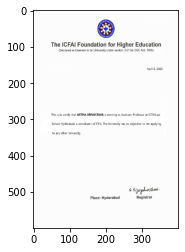

In [28]:
import matplotlib.pyplot as plt
plt.imshow(win)

In [16]:
cv.destroyAllWindows()